## Algoritmo Genético

No jupyter anterior utilizamos o algoritmo Gradiente Decrescente para otimizar a função objetivo, afim de comparações, dessa vez utilizaremos um algoritmo genético.

In [1]:
from random import randint, uniform, random
from tqdm import tqdm
import numpy as np

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

In [3]:
# Parâmetros iniciais

tamanhoPopulacao = 30
taxaMutacao = 0.01
taxaCrossover = 0.85
numeroGeracoes = 70
quantidadeVariaveis = 3 # Para o sistema dinâmico avaliado, apenas os controles devem ser avaliados
quantidadeTrocas = 2 # Posicoes a serem trocadas na 

In [4]:
def gerarPopulacao(xMin, xMax):
    populacao = np.zeros((tamanhoPopulacao,quantidadeVariaveis))
    for individuo in range(tamanhoPopulacao):
        for pos in range(quantidadeVariaveis):
            populacao[individuo,pos] = uniform(xMin, xMax)
    return populacao

In [5]:
def divisaoFitness(valorFuncaoObjetivo):
    divisao = 0
    for i in range(len(valorFuncaoObjetivo)):
        divisao += valorFuncaoObjetivo[i]
    return divisao

def fitness(valorFuncaoObjetivo):
    return valorFuncaoObjetivo/divisaoFitness(valorFuncaoObjetivo)

In [6]:
def calcularFuncao(populacao, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise):
    valorFuncaoObj = np.zeros(tamanhoPopulacao)
    for individuo in range(tamanhoPopulacao):
        valorFuncaoObj[individuo] = funcaoObjetivo(populacao[individuo,:], iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    return valorFuncaoObj

In [7]:
def selecao(valorFitness):
    pos = np.random.choice(range(tamanhoPopulacao), 2, replace=False)
    valor = valorFitness[pos[0]] < valorFitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [8]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [9]:
def mutacao(individuo):
    pos = np.random.choice(range(quantidadeVariaveis),  quantidadeTrocas ,replace=False)
    individuo[pos[0]] = individuo[pos[1]]
    individuo[pos[1]] = individuo[pos[0]]
    return individuo

In [10]:
import matplotlib.pyplot as plt

In [11]:
def main(xMin, xMax, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise):
    pop = gerarPopulacao(xMin, xMax)
    fo = calcularFuncao(pop, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    fit = fitness(fo)
    melhor_fo = np.zeros(numeroGeracoes)
    melhor_ind_geracao = np.zeros((numeroGeracoes, quantidadeVariaveis))
    for geracao in range(numeroGeracoes):
        new_pop = np.empty((0, quantidadeVariaveis))
        for i in range(round((tamanhoPopulacao) / 2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < taxaCrossover:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :]) 
                if random() < taxaMutacao:    
                    filho1 = mutacao(filho1)
                    filho2 = mutacao(filho2)  
                new_pop = np.vstack([new_pop, filho1, filho2])     
            else:
                pais = np.vstack([pop[pai1, :], pop[pai2, :]])
                new_pop = np.vstack([new_pop, pais])
        pop = new_pop    
        fo = calcularFuncao(pop, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)

    
    #plt.plot(melhor_fo)
    #plt.xlim(0, numeroGeracoes)
    #plt.ylabel('Gerações')
    #plt.ylabel('Melhor Custo')
    #plt.title('Evolução da função objetivo - GA')
    #plt.grid(True)
    #plt.show()
    

    return pop[pos_min_fo,:][0,0]

In [12]:
# Função de origem e destino
ondaOrigem = [[complex(1.0,0.0)],[complex(0.0,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

hamiltoniano = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
hamiltoniano = [[A, 0], [0, B]]

iteracao = 0
fatorRungeKutta = 0.01
tempoAnalise = 2000
horizonte = 3

xMin = -10
xMax = 10

constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1

minimo = main(xMin, xMax, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

In [13]:
minimo

array([-1.33962795,  5.57424328,  7.1455469 ])

In [14]:
while iteracao < 2000:
    
    print(f"Iteração: {iteracao}")
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, minimo[0]],[minimo[0],0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]

    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)

    print(ondaOrigem[0][0])
    print(ondaOrigem[1][0])
    print("--------------")
    
    ## Adaptação da onda ao controle
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(minimo, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)

    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]

    xMax = -minimo[0]
    xMin = minimo[0]
    
    A = (1/2*np.pi)
    B = (3/2*np.pi)
    hamiltoniano = [[A, 0], [0, B]]
    
    iteracao += 1

    minimo = main(xMax, xMin, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

Iteração: 0
(1+0j)
0j
--------------
Iteração: 1
(0.9997869368809428-0.01570496817394714j)
(0.0004207574107459499+0.013388717153237575j)
--------------
Iteração: 2
(0.9994965833716324-0.03141285556345812j)
(0.0006290240521189838+0.00440642893042676j)
--------------
Iteração: 3
(0.9988836594157148-0.04711262560314705j)
(0.0003454564404649508-0.0034228736687650727j)
--------------
Iteração: 4
(0.9979954968093299-0.06279693134228034j)
(-0.00016306196123105421-0.00784264707146693j)
--------------
Iteração: 5
(0.996863496762799-0.07846372654331217j)
(-0.0007658846088385167-0.010296882944933427j)
--------------
Iteração: 6
(0.995494321354335-0.0941106414548541j)
(-0.001388479362046119-0.011502842242535817j)
--------------
Iteração: 7
(0.99388210939832-0.1097338837585334j)
(-0.002046301547336006-0.012354754598945299j)
--------------
Iteração: 8
(0.9920266059484423-0.12532974864434002j)
(-0.002729243735805329-0.012969902138815253j)
--------------
Iteração: 9
(0.9899291338498765-0.1408947935538

Iteração: 72
(0.42572941941535203-0.9047294305664146j)
(0.0009161962555296325+0.014774282313446078j)
--------------
Iteração: 73
(0.4114660259933779-0.9113048834181586j)
(0.0016111431352367482+0.014714722260604862j)
--------------
Iteração: 74
(0.3971011094864906-0.917655485426294j)
(0.002302512874661873+0.014622491847385427j)
--------------
Iteração: 75
(0.382638214222888-0.9237796696748027j)
(0.0029887704602047853+0.01449779584833347j)
--------------
Iteração: 76
(0.36808090870556054-0.9296759251128609j)
(0.0036683922285066055+0.014340911119703328j)
--------------
Iteração: 77
(0.3534327847318173-0.9353427969276684j)
(0.004339869249289658+0.014152185984743534j)
--------------
Iteração: 78
(0.3386974565070603-0.9407788869034017j)
(0.005001710675785162+0.013932039460420428j)
--------------
Iteração: 79
(0.32387855975303637-0.9459828537662026j)
(0.005652447054611486+0.013680960327022295j)
--------------
Iteração: 80
(0.3089797508107761-0.9509534135151178j)
(0.006290633588386478+0.013399

Iteração: 143
(-0.6251769294438714-0.7803426734231206j)
(-0.0038931950372812474-0.01428152174784727j)
--------------
Iteração: 144
(-0.6373568928947686-0.7704265520822399j)
(-0.004561624876670151-0.0140822728806032j)
--------------
Iteração: 145
(-0.649379598069477-0.7603203395179677j)
(-0.005219926768810394-0.013851757848524764j)
--------------
Iteração: 146
(-0.6612420785453973-0.7500265292870295j)
(-0.005866639118997544-0.013590488452592161j)
--------------
Iteração: 147
(-0.6729414074329771-0.7395476612330675j)
(-0.006500326064206675-0.013299044776158585j)
--------------
Iteração: 148
(-0.6844746980978774-0.7288863208599727j)
(-0.0071195806610671-0.012978073897020211j)
--------------
Iteração: 149
(-0.6958391048732058-0.7180451386939506j)
(-0.007723028009628227-0.012628288450741784j)
--------------
Iteração: 150
(-0.7070318237616425-0.7070267896344778j)
(-0.00830932830598103-0.012250465048427561j)
--------------
Iteração: 151
(-0.718050093127285-0.695833992294311j)
(-0.008877179816

Iteração: 213
(-0.9791147998524067+0.20276856208345387j)
(0.006079383700098484+0.013496663384973802j)
--------------
Iteração: 214
(-0.9758090587455094+0.21812281386733537j)
(0.006708414706483258+0.013195302224384146j)
--------------
Iteração: 215
(-0.972262551354956+0.23342324711078824j)
(0.007322551355734161+0.012864644195480739j)
--------------
Iteração: 216
(-0.9684761527283768+0.2486660866608588j)
(0.00792043011102331+0.012505423441721524j)
--------------
Iteração: 217
(-0.9644507971029749+0.2638475715749754j)
(0.008500723532110364+0.012118437522951152j)
--------------
Iteração: 218
(-0.9601874776750171+0.2789639560489047j)
(0.00906214322259158+0.011704545644618815j)
--------------
Iteração: 219
(-0.955687246354778+0.29401151034097295j)
(0.009603442690461777+0.01126466675012743j)
--------------
Iteração: 220
(-0.9509512135069963+0.30898652169232366j)
(0.010123420115638073+0.010799777480549637j)
--------------
Iteração: 221
(-0.9459805476769092+0.3238852952429856j)
(0.0106209210183

Iteração: 284
(-0.2486591925385302+0.9684779228308134j)
(-0.008690021364589143-0.011983420005063325j)
--------------
Iteração: 285
(-0.23341632603536105+0.9722642129506496j)
(-0.009244870715019888-0.011560760864407573j)
--------------
Iteração: 286
(-0.2181158675464878+0.9758106114244846j)
(-0.009779194142144993-0.01111243394573707j)
--------------
Iteração: 287
(-0.202761592231093+0.9791162432315618j)
(-0.010291805314435363-0.01063943464684919j)
--------------
Iteração: 288
(-0.187357288526856+0.9821802927566968j)
(-0.010781566106993566-0.01014281314439071j)
--------------
Iteração: 289
(-0.17190675721521237+0.9850020039915186j)
(-0.011247389128475517-0.009623672062203208j)
--------------
Iteração: 290
(-0.1564138104835682+0.9875806807210029j)
(-0.011688240135370977-0.009083164023222592j)
--------------
Iteração: 291
(-0.1408822709846997+0.9899156866952529j)
(-0.012103140328282597-0.008522489090368145j)
--------------
Iteração: 292
(-0.12531597089357088+0.9920064457864846j)
(-0.012491

Iteração: 355
(0.7603249621019625+0.6493741856852956j)
(0.010939551047864773+0.009972213738201775j)
--------------
Iteração: 356
(0.7704310890817615+0.6373514085697731j)
(0.011397162354122255+0.009445819933159872j)
--------------
Iteração: 357
(0.7803471237187282+0.6251713745312419j)
(0.01182946911180619+0.008898454047496542j)
--------------
Iteração: 358
(0.7900706193796951+0.6128370888108443j)
(0.012235511491887681+0.008331331370264374j)
--------------
Iteração: 359
(0.7995991769376064+0.6003515947090168j)
(0.012614387978819553+0.007745711055530147j)
--------------
Iteração: 360
(0.8089304453634658+0.5877179728346015j)
(0.012965257372126142+0.007142893326738148j)
--------------
Iteração: 361
(0.8180621223064185+0.5749393403447518j)
(0.013287340654078552+0.006524216589889195j)
--------------
Iteração: 362
(0.8269919546618212+0.5620188501758208j)
(0.01357992271930868+0.005891054461944856j)
--------------
Iteração: 363
(0.8357177391271625+0.5489596902654208j)
(0.013842353962521817+0.005

Iteração: 426
(0.9176526585982316-0.39710764180833846j)
(-0.012734495071188782-0.007546618904220625j)
--------------
Iteração: 427
(0.9113019543333942-0.4114725131073885j)
(-0.013075852606379902-0.0069383643740136515j)
--------------
Iteração: 428
(0.9047263999476584-0.42573585972092476j)
(-0.013388178481161207-0.0063147049411360736j)
--------------
Iteração: 429
(0.897927617860675-0.4398941623816009j)
(-0.013670779254046863-0.005677025285379717j)
--------------
Iteração: 430
(0.89090728557019-0.4539439277400942j)
(-0.013923027480705463-0.00502674121493455j)
--------------
Iteração: 431
(0.8836671352381471-0.4678816892270371j)
(-0.014144363107043223-0.004365296522940699j)
--------------
Iteração: 432
(0.8762089532633021-0.48170400790834145j)
(-0.014334294712664022-0.0036941597819068754j)
--------------
Iteração: 433
(0.8685345798404562-0.49540747333370394j)
(-0.014492400601945466-0.0030148210831124175j)
--------------
Iteração: 434
(0.8606459085064156-0.5089887043780836j)
(-0.014618329

Iteração: 497
(0.04709773651535164-0.9987805986378103j)
(0.014000265756093252+0.004807429458336986j)
--------------
Iteração: 498
(0.03140376240474452-0.9993971606457515j)
(0.014211184640261259+0.004142589808949046j)
--------------
Iteração: 499
(0.01570203988567975-0.9997671363588541j)
(0.014390551143211871+0.003468552575079692j)
--------------
Iteração: 500
(-3.5568767649367394e-06-0.9998904344911471j)
(0.014537967026490796+0.002786814287827096j)
--------------
Iteração: 501
(-0.015709152761600224-0.9997670246206616j)
(0.014653104990003728+0.0020988885765521573j)
--------------
Iteração: 502
(-0.031410872648053347-0.9993969371969363j)
(0.014735709398704338+0.0014063028082430728j)
--------------
Iteração: 503
(-0.047104842371696126-0.9987802635335054j)
(0.014785596850167945+0.0007105946963789412j)
--------------
Iteração: 504
(-0.0627871896803371-0.9979171557853675j)
(0.01480265658179072+1.3308886821572952e-05j)
--------------
Iteração: 505
(-0.07845404518944178-0.9968078269114446j)
(

Iteração: 568
(-0.8762123803277742-0.48169777407177083j)
(-0.014684264864643927-0.001868470566415051j)
--------------
Iteração: 569
(-0.8836704639627974-0.4678754023294327j)
(-0.01475598050779704-0.0011746727598662102j)
--------------
Iteração: 570
(-0.8909105151337025-0.4539375893326597j)
(-0.014794934186787002-0.0004782668863527673j)
--------------
Iteração: 571
(-0.8979307474662-0.4398877740282494j)
(-0.014801039414717158+0.00021920085905831744j)
--------------
Iteração: 572
(-0.9047294288230099-0.42572942299789274j)
(-0.014774282636460844+0.0009161819236793515j)
--------------
Iteração: 573
(-0.9113048817312397-0.411466029602847j)
(-0.014714723258757131+0.00161112883537585j)
--------------
Iteração: 574
(-0.9176554837962768-0.39710111312200114j)
(-0.014622493518313016+0.002302498638341377j)
--------------
Iteração: 575
(-0.9237796681020893-0.3826382178835463j)
(-0.014497798188204873+0.002988756318845012j)
--------------
Iteração: 576
(-0.9296759235978396-0.3680809123904661j)
(-0.01

Iteração: 638
(-0.8269879561154044+0.5620247338069985j)
(0.014795770372956337-0.00045165651893052554j)
--------------
Iteração: 639
(-0.8180580318370599+0.5749451604435233j)
(0.014758069283361314-0.001148131322861049j)
--------------
Iteração: 640
(-0.8089262639804314+0.587723727964939j)
(0.014687601592016049-0.0018420569882382624j)
--------------
Iteração: 641
(-0.7995949056725937+0.6003572834509228j)
(0.014584523754809738-0.0025318928266778403j)
--------------
Iteração: 642
(-0.7900662592865788+0.6128427097607015j)
(0.014449064630304426-0.0032161072302335147j)
--------------
Iteração: 643
(-0.7803426758733+0.62517692630216j)
(0.014281524971611805-0.0038931810719494537j)
--------------
Iteração: 644
(-0.7704265545814648+0.6373568897919306j)
(0.01408227675864614-0.004561611078701721j)
--------------
Iteração: 645
(-0.7603203420656216+0.6493795950062778j)
(0.013851762372235885-0.005219913168840265j)
--------------
Iteração: 646
(-0.7500265318824837+0.6612420755225928j)
(0.01359049361192

Iteração: 709
(0.14088931376284777+0.9899146843154641j)
(-0.014396766041274128+0.0034426646260728184j)
--------------
Iteração: 710
(0.1564208366481362+0.9875795678415181j)
(-0.014218612126192551+0.0041170233599494635j)
--------------
Iteração: 711
(0.1719137650325928+0.9850007808869252j)
(-0.01400888933907789+0.004782241273046737j)
--------------
Iteração: 712
(0.18736427626796834+0.9821789597287787j)
(-0.013768063316930722+0.005436841415365259j)
--------------
Iteração: 713
(0.20276855817181028+0.9791148006092247j)
(-0.013496668753705818+0.006079370411010318j)
--------------
Iteração: 714
(0.21812280996806194+0.9758090595636756j)
(-0.013195308213157949+0.0067084016850495415j)
--------------
Iteração: 715
(0.23342324322484706+0.9722625522342684j)
(-0.012864650790999755+0.00732253863086573j)
--------------
Iteração: 716
(0.24866608278920865+0.9684761536686184j)
(-0.012505430629342052+0.00792041771097255j)
--------------
Iteração: 717
(0.26384756771857154+0.9644507981039138j)
(-0.012118

Iteração: 780
(0.950953411722194+0.3089797560926292j)
(0.01339951385036496-0.006290615103718143j)
--------------
Iteração: 781
(0.9556893380291669+0.2940047110478088j)
(0.013088310176610725-0.00691483524726076j)
--------------
Iteração: 782
(0.9601894622925058+0.278957124739901j)
(0.01274804718362692-0.007523702728486541j)
--------------
Iteração: 783
(0.9644526741738868+0.2638407099356616j)
(0.012379480340291927-0.00811586570943742j)
--------------
Iteração: 784
(0.9684779217895712+0.24865919638424813j)
(0.011983427957104746-0.008690009440320492j)
--------------
Iteração: 785
(0.9722642119699417+0.2334163298969597j)
(0.011560769369331184-0.009244859178581099j)
--------------
Iteração: 786
(0.9758106105045531+0.21811587142301433j)
(0.011112442984659816-0.009779183019149842j)
--------------
Iteração: 787
(0.9791162423726336+0.20276159612159098j)
(0.010639444199702404-0.010291794629579677j)
--------------
Iteração: 788
(0.9821802919589839+0.18735729243036547j)
(0.010142823189964668-0.010

Iteração: 851
(0.6958339962487787-0.7180500891934954j)
(-0.011845453946153819+0.008877163299908942j)
--------------
Iteração: 852
(0.6844695123444787-0.7288911905058498j)
(-0.0114141323730829+0.009425305808308006j)
--------------
Iteração: 853
(0.6729361458301186-0.73955244882376j)
(-0.010957468573890808+0.009952521782405778j)
--------------
Iteração: 854
(0.6612367423913056-0.7500312336412668j)
(-0.01047647645633296+0.010457640670995048j)
--------------
Iteração: 855
(0.6493741886807732-0.7603249594750164j)
(-0.009972223943110878+0.010939540983920538j)
--------------
Iteração: 856
(0.6373514116061435-0.7704310865021904j)
(-0.009445830600816925+0.011397152782067283j)
--------------
Iteração: 857
(0.6251713776077559-0.7803471211871685j)
(-0.008898465154216679+0.011829460052892836j)
--------------
Iteração: 858
(0.6128370919267427-0.7900706168967716j)
(-0.0083313428913879+0.012235502966228997j)
--------------
Iteração: 859
(0.600351597863531-0.7995991745039316j)
(-0.00774572296547729+0.0

Iteração: 922
(-0.3387041496711478-0.9407764771225245j)
(0.009799164241581339-0.011094826958752756j)
--------------
Iteração: 923
(-0.35343943921892174-0.9353402823122335j)
(0.009265648046373863-0.011544114142088339j)
--------------
Iteração: 924
(-0.36808752287378166-0.9296733062833143j)
(0.008711559797158507-0.011967770507160046j)
--------------
Iteração: 925
(-0.3826447864402734-0.923776947277304j)
(0.00813812970831476-0.012364855430972306j)
--------------
Iteração: 926
(-0.3971076381314406-0.9176526601325566j)
(0.007546630937939299-0.012734487285769319j)
--------------
Iteração: 927
(-0.41147250945504443-0.9113019559252841j)
(0.006938376761116856-0.01307584539646898j)
--------------
Iteração: 928
(-0.4257358560940356-0.9047264015967204j)
(0.006314717654121344-0.01338817186276663j)
--------------
Iteração: 929
(-0.4398941587810615-0.8979276195665022j)
(0.0056770382960210485-0.01367077324186312j)
--------------
Iteração: 930
(-0.4539439241667929-0.8909072873323617j)
(0.00502675449434

Iteração: 993
(-0.9938524414465951-0.10971875649749106j)
(-0.0073456769249131085+0.012851452572662927j)
--------------
Iteração: 994
(-0.9954532196598092-0.09409446511577985j)
(-0.0067321360128736645+0.013183214607350415j)
--------------
Iteração: 995
(-0.9968083846866073-0.07844695733279383j)
(-0.006103648076661296+0.013485706611158318j)
--------------
Iteração: 996
(-0.9979176021602972-0.06278009393693587j)
(-0.005461608516551774+0.01375825697625182j)
--------------
Iteração: 997
(-0.9987805983980654-0.04709774049231667j)
(-0.004807442820812173+0.014000260572716377j)
--------------
Iteração: 998
(-0.9993971604685036-0.031403766384984676j)
(-0.004142603400760693+0.014211180092097334j)
--------------
Iteração: 999
(-0.9997671362441469-0.015702043868212966j)
(-0.0034685663660505794+0.014390547240358955j)
--------------
Iteração: 1000
(-0.999890434439009+3.5528929212963467e-06j)
(-0.002786828247337822+0.014537963777614198j)
--------------
Iteração: 1001
(-0.9997670246311054+0.01570914877

Iteração: 1063
(-0.548959694886962+0.8357177360040445j)
(0.005244831191350026-0.013842346121760468j)
--------------
Iteração: 1064
(-0.5357650874358749+0.8442373196955539j)
(0.0045869450045182255-0.014074044758795637j)
--------------
Iteração: 1065
(-0.5224382879664251+0.8525486004612322j)
(0.003918874653628274-0.014274495499417481j)
--------------
Iteração: 1066
(-0.508982584666965+0.8606495276169168j)
(0.003242103421807195-0.014443253292895218j)
--------------
Iteração: 1067
(-0.4954012975309385+0.8685381023800511j)
(0.0025581339103117468-0.014579943454760654j)
--------------
Iteração: 1068
(-0.4816977775377218+0.8762123783628536j)
(0.0018684847023781397-0.01468426249870133j)
--------------
Iteração: 1069
(-0.4678754058258197+0.8836704620525601j)
(0.0011746869915877662-0.014755978810375959j)
--------------
Iteração: 1070
(-0.4539375928586201+0.8909105132786197j)
(0.0004782811822348123-0.014794933161656131j)
--------------
Iteração: 1071
(-0.4398877775829132+0.8979307456667295j)
(-0.0

Iteração: 1133
(0.4954074684528494+0.8685345825404134j)
(-0.0030148405525724747+0.014492395747105084j)
--------------
Iteração: 1134
(0.5089886995402403+0.8606459112827048j)
(-0.0023288084047730947+0.014618325807994761j)
--------------
Iteração: 1135
(0.5224443452823057+0.8525448885247257j)
(-0.0016376057204651392+0.014711799532545628j)
--------------
Iteração: 1136
(0.5357710856998031+0.8442335130726211j)
(-0.0009427671423356782+0.014772609385735635j)
--------------
Iteração: 1137
(0.5489656326189504+0.8357138356339161j)
(-0.0002458353856644184+0.014800620354499673j)
--------------
Iteração: 1138
(0.5620247304827327+0.826987958311534j)
(0.00045164218688973333+0.014795770247492311j)
--------------
Iteração: 1139
(0.574945157154163+0.818058034085134j)
(0.001148117000820449+0.014758069833168113j)
--------------
Iteração: 1140
(0.5877237247112957+0.8089262662798952j)
(0.0018420427079963641+0.014687602815872966j)
--------------
Iteração: 1141
(0.6003572802337993+0.7995949080228798j)
(0.002

Iteração: 1204
(0.9979171560627247-0.06278718410937825j)
(1.3328936260700863e-05-0.014802655775976668j)
--------------
Iteração: 1205
(0.9968078272762724-0.07845403962352673j)
(-0.0006839864065435383-0.014786850856248715j)
--------------
Iteração: 1206
(0.9954525510742451-0.09410153777734748j)
(-0.0013797831284954039-0.01473821543248305j)
--------------
Iteração: 1207
(0.9938516618507661-0.1097258177848135j)
(-0.0020725163869972528-0.014656857487479108j)
--------------
Iteração: 1208
(0.9920055546012961-0.12532302458862798j)
(-0.002760648141106076-0.0145429576562106j)
--------------
Iteração: 1209
(0.9899146848251749-0.14088930981140202j)
(-0.003442650566368738-0.01439676882477073j)
--------------
Iteração: 1210
(0.9875795684132326-0.15642083270518412j)
(-0.004117009446974053-0.014218615568901855j)
--------------
Iteração: 1211
(0.9850007815205023-0.17191376109910728j)
(-0.004782227537690278-0.01400889343335622j)
--------------
Iteração: 1212
(0.982178960424062-0.18736427234491987j)
(-

Iteração: 1274
(0.3971011182116793-0.9176554815142414j)
(0.0023024787096868104+0.014622495858840453j)
--------------
Iteração: 1275
(0.38263822300844125-0.9237796659002806j)
(0.002988736522567679+0.014497801464902177j)
--------------
Iteração: 1276
(0.36808091754931327-0.9296759214768008j)
(0.0036683585933980018+0.014340918328823128j)
--------------
Iteração: 1277
(0.3534327936315882-0.9353427934309675j)
(0.004339835991348346+0.014152194770374384j)
--------------
Iteração: 1278
(0.3386974654606545-0.9407788835469227j)
(0.005001677868798601+0.013932049803021351j)
--------------
Iteração: 1279
(0.32387856875824517-0.9459828505507738j)
(0.005652414771392252+0.013680972203609146j)
--------------
Iteração: 1280
(0.308979759865378-0.9509534104415325j)
(0.006290601900592247+0.013399519427155851j)
--------------
Iteração: 1281
(0.2940047148402079-0.9556893368079231j)
(0.0069148223214948+0.013088316369163053j)
--------------
Iteração: 1282
(0.2789571285510147-0.9601894611309811j)
(0.00752369010

Iteração: 1344
(-0.6373568854479567-0.7704265580803786j)
(-0.004561591761540488-0.014082282187883577j)
--------------
Iteração: 1345
(-0.6493795907177984-0.760320345632336j)
(-0.005219894128875592-0.013851768705409054j)
--------------
Iteração: 1346
(-0.6612420712906659-0.7500265355161185j)
(-0.005866607026726413-0.013590500834975369j)
--------------
Iteração: 1347
(-0.6729414002769831-0.7395476675753404j)
(-0.0065002945908520775-0.013299058656548724j)
--------------
Iteração: 1348
(-0.6844746910423862-0.7288863273138647j)
(-0.007119549876507748-0.012978089244599348j)
--------------
Iteração: 1349
(-0.6958390979199582-0.7180451452578692j)
(-0.007722997982213535-0.012628305231434456j)
--------------
Iteração: 1350
(-0.7070318169123543-0.7070267963068035j)
(-0.008309299102379363-0.012250483224976438j)
--------------
Iteração: 1351
(-0.7180500863836461-0.6958339990733975j)
(-0.00887715150200818-0.011845462084499192j)
--------------
Iteração: 1352
(-0.7288911877407143-0.6844695152128842j)


Iteração: 1414
(-0.9758090607091077+0.21812280450907892j)
(0.006708383455033436+0.013195316597419725j)
--------------
Iteração: 1415
(-0.9722625534653052+0.23342323778452917j)
(0.00732252081604002+0.012864660024705273j)
--------------
Iteração: 1416
(-0.9684761549849562+0.2486660773688982j)
(0.0079204003508906+0.012505440691990177j)
--------------
Iteração: 1417
(-0.9644507995052277+0.26384756231960593j)
(0.008500694617614019+0.012118456155964016j)
--------------
Iteração: 1418
(-0.9601874802223507+0.27896394683241j)
(0.009062115217929005+0.011704565619005946j)
--------------
Iteração: 1419
(-0.9556872490465637+0.294011501165627j)
(0.009603415657810322+0.011264688021540696j)
--------------
Iteração: 1420
(-0.95095121634257+0.3089865125603904j)
(0.010123394115016981+0.010799800001761185j)
--------------
Iteração: 1421
(-0.9459805506555713+0.3238852861567182j)
(0.010620896107437943+0.01031093372724766j)
--------------
Iteração: 1422
(-0.940776478422947+0.33870414590516434j)
(0.0110948170

Iteração: 1485
(-0.23341633530319766+0.9722642105969522j)
(-0.009244843027553712-0.011560781276204942j)
--------------
Iteração: 1486
(-0.21811587685015132+0.9758106092166504j)
(-0.009779167446942653-0.011112455639132999j)
--------------
Iteração: 1487
(-0.20276160156828793+0.9791162411701356j)
(-0.010291779670766879-0.010639457573678918j)
--------------
Iteração: 1488
(-0.1873572978952785+0.9821802908421873j)
(-0.010781541571794291-0.010142837253750946j)
--------------
Iteração: 1489
(-0.17190676661255094+0.985002002224398j)
(-0.011247365756219724-0.009623697300565146j)
--------------
Iteração: 1490
(-0.15641381990750416+0.9875806791017073j)
(-0.011688217977950915-0.009083190334550763j)
--------------
Iteração: 1491
(-0.14088228043290782+0.9899156852241818j)
(-0.012103119434893275-0.008522516416244826j)
--------------
Iteração: 1492
(-0.12531598036372+0.992006444464001j)
(-0.01249114894213512-0.007942920381857855j)
--------------
Iteração: 1493
(-0.10971876045155529+0.9938524409576076

Iteração: 1555
(0.7603249557972931+0.6493741928744421j)
(0.010939526894382668+0.009972238229966601j)
--------------
Iteração: 1556
(0.770431082890792+0.6373514158570621j)
(0.0113971393811736+0.009445845535520544j)
--------------
Iteração: 1557
(0.7803471176429861+0.6251713819148754j)
(0.011829447370396672+0.008898480703609423j)
--------------
Iteração: 1558
(0.7900706134206797+0.6128370962890005j)
(0.012235491030288662+0.00833135902094623j)
--------------
Iteração: 1559
(0.7995991710967879+0.6003516022798506j)
(0.012614368842460894+0.007745739639389557j)
--------------
Iteração: 1560
(0.8089304396422854+0.5877179804962449j)
(0.01296523960349534+0.007142922780311799j)
--------------
Iteração: 1561
(0.8180621167062877+0.5749393480953144j)
(0.01328732429262641+0.006524246847782794j)
--------------
Iteração: 1562
(0.8269919491841219+0.5620188580133902j)
(0.013579907801361712+0.005891085456978317j)
--------------
Iteração: 1563
(0.8357177337732462+0.5489596981880633j)
(0.013842340521201592+

Iteração: 1626
(0.9176526622806122-0.39710763298378415j)
(-0.012734476386163025-0.007546647785132005j)
--------------
Iteração: 1627
(0.9113019581539306-0.4114725043417632j)
(-0.013075835302574031-0.0069383941030488165j)
--------------
Iteração: 1628
(0.9047264039054078-0.42573585101639116j)
(-0.013388162596993996-0.006314735452289138j)
--------------
Iteração: 1629
(0.897927621954661-0.43989415374030677j)
(-0.013670764824785133-0.0056770565109082955j)
--------------
Iteração: 1630
(0.8909072897994026-0.45394391916417165j)
(-0.01392301453838578-0.005026773085510167j)
--------------
Iteração: 1631
(0.8836671396015426-0.46788168071860214j)
(-0.014144351680400772-0.004365328967802711j)
--------------
Iteração: 1632
(0.876208957759804-0.48170399946949344j)
(-0.014334284827068803-0.003694192729019582j)
--------------
Iteração: 1633
(0.868534584468955-0.495407464966525j)
(-0.01449239227934597-0.0030148544593249947j)
--------------
Iteração: 1634
(0.8606459132657694-0.5089886960846383j)
(-0.0

Iteração: 1697
(0.04709774606006826-0.998780598062423j)
(0.014000253315967381+0.0048074615282681565j)
--------------
Iteração: 1698
(0.03140377195732143-0.9993971602203571j)
(0.014211173724646054+0.004142622429288736j)
--------------
Iteração: 1699
(0.015702049443759986-0.9997671360835575j)
(0.014390541776342724+0.0034685856734025947j)
--------------
Iteração: 1700
(-3.5473155396877065e-06-0.9998904343660163j)
(0.014537959229164498+0.002786847790646664j)
--------------
Iteração: 1701
(-0.015709143199589055-0.9997670246457274j)
(0.014653098779532291+0.002098922409483759j)
--------------
Iteração: 1702
(-0.03141086308761554-0.9993969373721926j)
(0.01473570478887656+0.0014063368961691452j)
--------------
Iteração: 1703
(-0.04710483281519057-0.9987802638589088j)
(0.014785593851218796+0.0007106289636157698j)
--------------
Iteração: 1704
(-0.06278718013012172-0.997917156260838j)
(0.014802655200378616+1.334325728732889e-05j)
--------------
Iteração: 1705
(-0.07845403564787296-0.9968078275368

Iteração: 1767
(-0.8685380995532856-0.4954013023394634j)
(-0.014579939213842518-0.002558153522652876j)
--------------
Iteração: 1768
(-0.8762123756119659-0.4816977823900544j)
(-0.014684259186358887-0.001868504492721711j)
--------------
Iteração: 1769
(-0.8836704593782287-0.4678754107207628j)
(-0.014755976433963433-0.0011747069159942715j)
--------------
Iteração: 1770
(-0.8909105106815047-0.45393759779496584j)
(-0.014794931726449755-0.0004783011964670903j)
--------------
Iteração: 1771
(-0.8979307431474717-0.43988778255944366j)
(-0.014801038573338837+0.00021916647113476057j)
--------------
Iteração: 1772
(-0.9047294246388164-0.4257294315958702j)
(-0.014774283415909518+0.0009161475342963443j)
--------------
Iteração: 1773
(-0.9113048776826137-0.41146603826548617j)
(-0.014714725657302228+0.0016110945208864164j)
--------------
Iteração: 1774
(-0.9176554798842171-0.3971011218471646j)
(-0.014622497530629166+0.002302464474932259j)
--------------
Iteração: 1775
(-0.9237796643275612-0.382638226

Iteração: 1837
(-0.8357138386350182+0.548965627917259j)
(0.014800619233837664+0.0002458554199705862j)
--------------
Iteração: 1838
(-0.826987961386117+0.5620247258287606j)
(0.014795770071819394-0.00045162212203374253j)
--------------
Iteração: 1839
(-0.818058037232439+0.5749451525490584j)
(0.014758070602874327-0.0011480969499636298j)
--------------
Iteração: 1840
(-0.8089262694991457+0.587723720156195j)
(0.01468760452924937-0.001842022715656629j)
--------------
Iteração: 1841
(-0.7995949113132815+0.6003572757298263j)
(0.014584528303241973-0.0025318587305056886j)
--------------
Iteração: 1842
(-0.7900662650478485+0.6128427021291577j)
(0.014449070779836919-0.003216073386172867j)
--------------
Iteração: 1843
(-0.7803426817537299+0.6251769187620517j)
(0.014281532708591059-0.0038931475551425817j)
--------------
Iteração: 1844
(-0.7704265605796042+0.6373568823451182j)
(0.014082286065894125-0.004561577963564311j)
--------------
Iteração: 1845
(-0.7603203481799905+0.6493795876545988j)
(0.013

Iteração: 1907
(0.10972581223310393+0.9938516623902443j)
(-0.014656859514667575+0.0020724964240363074j)
--------------
Iteração: 1908
(0.12532301904607707+0.9920055552279102j)
(-0.014542960621532833+0.0027606282958001632j)
--------------
Iteração: 1909
(0.1408893042793773+0.9899146855387702j)
(-0.01439677272164297+0.0034426308827793955j)
--------------
Iteração: 1910
(0.15642082718505051+0.9875795692136331j)
(-0.014218620388672071+0.004116989968803768j)
--------------
Iteração: 1911
(0.17191375559222682+0.9850007824075107j)
(-0.01400889916532332+0.004782208308185456j)
--------------
Iteração: 1912
(0.1873642668526513+0.9821789613974593j)
(-0.013768074685125338+0.005436808949978622j)
--------------
Iteração: 1913
(0.2027685487838653+0.9791148024255889j)
(-0.01349668163860939+0.006079338517179598j)
--------------
Iteração: 1914
(0.21812280060980535+0.9758090615272751j)
(-0.01319532258616277+0.006708370433587011j)
--------------
Iteração: 1915
(0.23342323389858785+0.9722625543446188j)
(-0

Iteração: 1978
(0.9407788815889748+0.33869747068358036j)
(0.01393205583632273-0.005001658731699222j)
--------------
Iteração: 1979
(0.9459828486751056+0.32387857401128084j)
(0.013680979131693598-0.005652395939744848j)
--------------
Iteração: 1980
(0.9509534086486068+0.30897976514722736j)
(0.013399527234641296-0.006290583416207782j)
--------------
Iteração: 1981
(0.9556893350981822+0.2940047201495677j)
(0.013088325038714923-0.0069148042254132255j)
--------------
Iteração: 1982
(0.960189459504847+0.27895713388657495j)
(0.012748063490561396-0.007523672441178087j)
--------------
Iteração: 1983
(0.9644526715302417+0.26384071912499385j)
(0.012379498055851212-0.008115836223913438j)
--------------
Iteração: 1984
(0.968477919290592+0.24865920561397128j)
(0.01198344704195587-0.008689980822046214j)
--------------
Iteração: 1985
(0.9722642096162452+0.23341633916479645j)
(0.011560789781101009-0.009244831491096244j)
--------------
Iteração: 1986
(0.9758106082967197+0.21811588072667798j)
(0.01111246

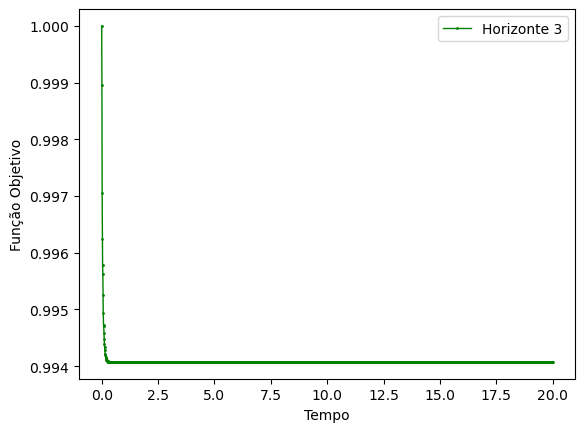

In [15]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0])/abs(valoresFuncaoObjetivo3[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.legend(loc="upper right")
plt.show()

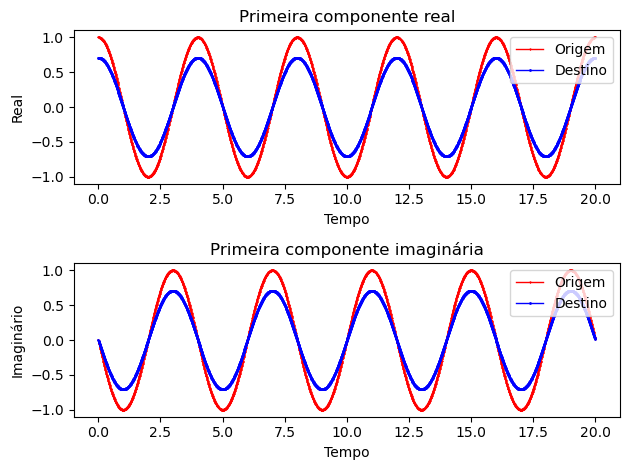

In [16]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()
